# Introduction
機械学習とは、その名の通り「機械」を「学習」させることで、あるデータに対して予測を行えるようにすることです。

* 機械とは、具体的には数理・統計的なモデルになります。
* 学習とは、そのモデルのパラメータを、実際のデータに沿うよう調整することです。

![](./pictures/machine_learning.PNG)

学習の方法は大きく分けて2つあります。  

* 教師有り学習(Supervised learning): データと、そこから予測されるべき値(正解)を与えることで学習させます。
 * 分類(Classification): データがいくつかのカテゴリに分類できるとき、そのカテゴリを予測させます(例：手書きの数字が0～9の何れかであるか判別するなど)
 * 回帰(Regression): データから予測される連続的な値を予測します(例：年齢と体重から慎重を予測するなど)。
* 教師なし学習(Unsupervised learning): データを与えることで、その裏側にある構造を学習させます
 * クラスタリング: 似ているデータをまとめることで、データがどれくらいの集合(クラスタ)から構成されるのかを予測します。
 * 分布推定： データを生み出している確率分布の推定を行います。

[scikit-learn](http://scikit-learn.org/stable/index.html)は、Python製の機械学習ライブラリです。  
この中には様々な「機械」が実装されており、その「学習」のための仕組みも備わっています。  

以下では、このscikit-learnを利用しデータを準備するところから実際にモデルを構築し学習・評価を行うまでの手順を解説します。

1. [データの準備](#Loading-the-Data) 
2. [データの整備](#Arrange-the-Data) 
3. [モデルの選択](#Select-the-Model)
4. [データの分割](#Split-the-Data) 
5. [モデルの学習](#Training-the-Model)
6. [モデルの評価](#Evaluate-Training-Result)
7. [モデルの保管](#Store-the-Model)

環境のセットアップについては、以下にまとめてあるのでご参考ください。

[Pythonで機械学習アプリケーションの開発環境を構築する](http://qiita.com/icoxfog417/items/950b8af9100b64c0d8f9)



In [13]:
# enable showing matplotlib image inline
%matplotlib inline

## Loading the Data

scikit-learnでは、よく例として利用されるデータセット(irisのデータや手書き文字のデータなど)を以下のように簡単に取得することができます。

[Dataset loading utilities](http://scikit-learn.org/stable/datasets/index.html#datasets)

In [11]:
from sklearn import datasets
iris = datasets.load_iris()
digits = datasets.load_digits()

`dataset`は、以下の内容で構成されています。

* `data`: データ本体(常にサンプル×特徴量の二次元配列。画像などデータ自体が2次元で表示される場合は、`images`からアクセスできる)
* `target`: データから予測されるべき正解(教師データ)
* `feature_names`: 特徴量項目の名前
* `target_names` : 予測値項目の名前
* `DESCR`: データの説明

In [14]:
print(iris.keys())

dict_keys(['target', 'feature_names', 'target_names', 'data', 'DESCR'])


通常のデータ読み込みには、Pythonに標準で搭載されている`csv`などが使えます。

In [15]:
import csv
import numpy as np

encoding = "utf-8"
ratings = []
with open("./data/ratings.txt", encoding="utf-8") as f:
    content = csv.reader(f, delimiter="\t")
    lines = list(content)
    ratings = np.array(lines)

print(ratings)

[['1' 'good']
 ['2' 'bad']
 ['3' 'vgood']]


なお、このようなデータの読み込み、また読み込んだデータに対する操作をサポートするライブラリとして[pandas](http://pandas.pydata.org/)があります。

## Arrange the Data

データの中の各特徴量は、別々の平均・分散を持っています(例: 体重と身長では平均も分散も異なる)。  
この状態だと学習が効率的に進まないため、各特徴量の平均を0・分散を1にそろえる正規化(Normalization)を行うことが一般的です。  
(これに加え、特徴量間の相関を消す白色化(Whitening)まで行うこともあります)。  

scikit-learnでは[`preprocessing`](http://scikit-learn.org/stable/modules/preprocessing.html)を使用することでこの作業をとても簡単に行うことができます。以下では、`StandardScaler`を使って処理を行っています。

In [4]:
from sklearn import datasets
import numpy as np
from sklearn import preprocessing

iris_data = iris["data"]
scaler = preprocessing.StandardScaler().fit(iris_data)
describe = lambda t, x: (t + ":\n {0}").format({"mean": np.mean(x, axis=0), "std": np.std(x, axis=0)})

# before scaling
print(describe("Before scaling", iris_data))

# scaling
iris_data_scaled = scaler.transform(iris_data)
print(describe("After scaling (mean is almost 0, std = 1)", iris_data_scaled))

# inverse
iris_data_inv = scaler.inverse_transform(iris_data_scaled)
print(describe("Inverse the scaling", iris_data_inv))

Before scaling:
 {'mean': array([ 5.84333333,  3.054     ,  3.75866667,  1.19866667]), 'std': array([ 0.82530129,  0.43214658,  1.75852918,  0.76061262])}
After scaling (mean is almost 0, std = 1):
 {'mean': array([ -1.69031455e-15,  -1.63702385e-15,  -1.48251781e-15,
        -1.62314606e-15]), 'std': array([ 1.,  1.,  1.,  1.])}
Inverse the scaling:
 {'mean': array([ 5.84333333,  3.054     ,  3.75866667,  1.19866667]), 'std': array([ 0.82530129,  0.43214658,  1.75852918,  0.76061262])}


※`preprocessing`には`Normalization`というモジュールがありますが、これは一般的に言う正規化を行うためのものではないので注意してください。  

また、データの中にはテキストである項目が含まれていることもあります。

In [17]:
print(ratings)

[['1' 'good']
 ['2' 'bad']
 ['3' 'vgood']]


上記の`good`などのテキスト項目は、最終的には数値にしないとデータを学習させることができません。  これも`preprocessing`を利用することで簡単に数値へ変換することができます。

In [20]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(["bad", "nbad", "good", "vgood"])

encoded_rating = le.transform(ratings[:, 1])
print("{0} is encoded to {1}".format(ratings[:, 1], encoded_rating))

['good' 'bad' 'vgood'] is encoded to [1 0 3]


[Feature Extraction](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction)では、テキスト/画像についてより強力に特徴量の数値化(ベクトル化)を行う機能がサポートされています。以下では、cityというテキストの項目がDubai/London/San Fransiscoを表す0/1の特徴量へと変換されています。

In [19]:
from sklearn.feature_extraction import DictVectorizer

measurements = [
    {"city": "Dubai", "temperature": 33.},
    {"city": "London", "temperature": 12.},
    {"city": "San Fransisco", "temperature": 18.},
    {"city": "Dubai", "temperature": 32.},
]

vec = DictVectorizer()
vectorized = vec.fit_transform(measurements).toarray()
print(vectorized)

feature_names = vec.get_feature_names()
print(feature_names)

[[  1.   0.   0.  33.]
 [  0.   1.   0.  12.]
 [  0.   0.   1.  18.]
 [  1.   0.   0.  32.]]
['city=Dubai', 'city=London', 'city=San Fransisco', 'temperature']


`preprocessing`には、他にも欠損値の修正を行う`Imputer`などデータの整備に役立つモジュールが含まれています。

### Dimensionality reduction

データを図示することは、この後のモデルの選択を行う時を含め、様々なシーンで非常に重要です。
しかし、単純に特徴量が4つになっただけでもデータを図示することができなくなってしまいますし(4次元の図になってしまうため)、場合によっては非常に多くなることもあります(テキスト解析など)。

そのため、データをなるべく少ない、必要最小限の特徴量で表現することが重要になります。これを行うのがDimensionality reduction(次元削除/次元圧縮)と呼ばれる手法です。

具体的には、データの中に身長と体重があった場合、これらは体が大きくなれば両方とも増える特徴量のため、データの特性を表す上ではどちらかひとつで十分です。このように片方が増えれば片方も増えるといった、互いに相関のある特徴量を消していけば必要最小限の特徴量でデータを表現することができる・・・というのが基本的な考え方です。

scikit-learnでは[`decomposition`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition)を利用しこの処理を行うことができます。以下では、[TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)によって数字データの特徴量を、上記で述べたとおり互いに相関のない、2つの特徴量へと圧縮しています。


### Visualize

実際にデータを図示するには、scikit-learnではなく[matplotlib](http://matplotlib.org/examples/index.html)を利用します。
以下では、最初の2つの特徴量をピックアップし、irisのデータをプロットしています。


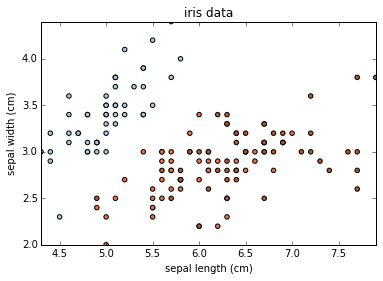

In [22]:
import matplotlib.pyplot as plt

features = iris.data[:, :2]  # select first 2 feature
label = iris.target

plt.scatter(features[:, 0], features[:, 1], c=label, cmap=plt.cm.Paired)

for i in range(features.shape[1]):
    f_data = features[:, i]
    if i == 0:
        plt.xlabel(iris.feature_names[i])
        plt.xlim(f_data.min(), f_data.max())
    else:
        plt.ylabel(iris.feature_names[i])
        plt.ylim(f_data.min(), f_data.max())

plt.title("iris data")


In [8]:
from sklearn import decomposition

digits_data = digits["data"]
show_dimension = lambda dset: len(dset[0])

dimension = 2
digits_recuced = decomposition.TruncatedSVD(n_components=dimension).fit_transform(digits_data)

print("Dimension is reduced from {0} to {1}.".format(show_dimension(digits_data), show_dimension(digits_recuced)))


Dimension is reduced from 64 to 2.


## Select the Model

機械学習に使えるモデルには色々なものがあり、scikit-learnでも様々なモデルが使えるようになっています。  
ただ、その分一体どれを選べば良いのかは非常に悩ましい問題です。  

一つの基準として、以下のようなフローチャートがあります。これは、scikit-learnの中のアルゴリズムをどのような基準で選択したらよいのかを図示したものです。

[Choosing the right estimator](http://scikit-learn.org/stable/tutorial/machine_learning_map/)

scikit-learnにはNeural Networkがないため図中にもありませんが、基本的にはSVC/SVRの代替であり、データが多いほど精度が向上します。

ポイントとしては以下になります。

* 最低でも50件以上はデータを集める
* 単純なモデルから始める(ClassificationならLinerSVC、RegressionならRasso/ElasticNetなど)
* Just lookingから始める(データを見て、必要に応じ次元削除を行う)

機械学習で正しい結果を出すにはデータの整備(図中ではJust looking、[前章](#Arrange-the-Data)に当たる部分)が欠かせません。データ整備した上で単純なモデルで検証をしてみて、必要に応じ他のモデルを試していくというのが基本的な進め方になります。


### Select Model Features

特徴量が多い場合は、どの特徴量をモデルに使うのかも重要な問題です。scikit-learnには、どの特徴量が予測値に寄与しているか調べるための機能があります。  以下では、[Feature selection](http://scikit-learn.org/stable/modules/feature_selection.html)を利用し特徴量をもっとも有用な2つに絞っています(k=2)。

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X, y = iris.data, iris.target
print(X.shape)

X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
print(X_new.shape)


(150, 4)
(150, 2)


## Split the Data

学習に当たっては、データを学習用(training set)と評価用(test set)に分けておきます。学習に使ったデータに対して予測がうまくできるのは当たり前なので、正確に精度を測定するため、評価用のデータは学習用とは別にしておきます。

単純に学習用と評価用に2分割するのでなく、データ全体を何個かに分割し、評価用として使うデータを切り替えていくという方法もあります。これにより、少ないデータでも効率的に学習を行うことができます。

[K-FOLD CROSS-VALIDATION, WITH MATLAB CODE](https://chrisjmccormick.wordpress.com/2013/07/31/k-fold-cross-validation-with-matlab-code/)

![cross_validation](./pictures/cross_validation.PNG)

これはCross Validationと呼ばれる手法ですが、scikit-learnでは単純な分割からこのCross Validationまで、[`cross-validation`](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)で行えるようになっています。


In [3]:
from sklearn import cross_validation

test_size = 0.3  # use 30% of data to test the model
X_train, X_test, y_train, y_test = cross_validation.train_test_split(iris.data, iris.target, test_size=test_size, random_state=0)
test_data_rate = X_test.shape[0] * 100 / (X_train.shape[0] + X_test.shape[0])

print("test data is {0}% of data".format(test_data_rate))

test data is 30.0% of data


Cross Validationを利用する際は、データの分割と学習を合わせて行ってくれる`cross_val_score`を利用するのが簡単ですが(後述します)、データの分割のみ行う場合は`KFold`を利用します。

In [4]:
from sklearn.cross_validation import KFold

length = len(iris.target)
split_count = 3  # divide into 3 set
kf = KFold(length, n_folds=split_count)

for i, train_test_indexes in enumerate(kf):
    train, test = train_test_indexes
    x_train = iris.data[train]
    y_train = iris.target[train]
    
    x_test = iris.data[test]
    y_test = iris.target[test]

    print("{0}: training {1}, test {2}".format(i, len(y_train), len(y_test)))


0: training 100, test 50
1: training 100, test 50
2: training 100, test 50


これでデータの準備は整ったので、いよいよ学習を行っていきます。

## Training the Model

以下では、分類を行う際によく利用される[Support Vector Machine](http://scikit-learn.org/stable/modules/svm.html)をベースにその学習方法などを解説していきます。

In [10]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)

モデルの構築はたったこれだけでおしまいです。そして、学習もたった一行で済ませることができます(以下の例では、最後の1データ以外を学習データとして渡しています)。

In [4]:
clf.fit(digits.data[:-1], digits.target[:-1])

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

そして、取っておいた最後の一つのデータについて、モデルを使って予測させてみます。

In [5]:
clf.predict(digits.data[-1])

array([8])

実際判定した画像は以下です。「8」という予測はそこそこ的を得ているのではないかと思います。

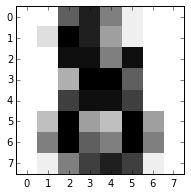

In [8]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

今度はCross Validationを使ってみます。`cv`ではデータの分割数(foldの数)を指定します。

In [11]:
from sklearn import cross_validation

scores = cross_validation.cross_val_score(clf, digits.data, digits.target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.03)


### Search Model Parameters

上記ではモデルのパラメータを固定で指定しましたが(`gamma=0.001`など)、実際どんなパラメータを設定すべきかは非常に悩ましい問題です。  
最適なパラメータを探すため、各パラメータが取りうる範囲を決め、その組み合わせを試していくという手法があります。これをGrid Searchと呼びますが、scikit-learnではこれを行うための[Grid Search](http://scikit-learn.org/stable/modules/grid_search.html#grid-search)モジュールが提供されています。

In [16]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC


candidates = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
              {'kernel': ['linear'], 'C': [1, 10, 100]}]

clf = GridSearchCV(SVC(C=1), candidates, cv=5, scoring="f1")
clf.fit(digits.data, digits.target)

print(clf.best_estimator_)

for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() / 2, params))


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.001,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.972 (+/-0.008) for {'kernel': 'rbf', 'gamma': 0.001, 'C': 1}
0.947 (+/-0.011) for {'kernel': 'rbf', 'gamma': 0.0001, 'C': 1}
0.973 (+/-0.007) for {'kernel': 'rbf', 'gamma': 0.001, 'C': 10}
0.959 (+/-0.012) for {'kernel': 'rbf', 'gamma': 0.0001, 'C': 10}
0.973 (+/-0.007) for {'kernel': 'rbf', 'gamma': 0.001, 'C': 100}
0.963 (+/-0.009) for {'kernel': 'rbf', 'gamma': 0.0001, 'C': 100}
0.949 (+/-0.010) for {'kernel': 'linear', 'C': 1}
0.949 (+/-0.010) for {'kernel': 'linear', 'C': 10}
0.949 (+/-0.010) for {'kernel': 'linear', 'C': 100}


### Ensemble Lerning

学習の結果、優秀なモデルができることもあればそうでないこともあります。
特徴量が増える、つまり多次元になるほど「よさそうに見えるパラメーターの組み合わせ」は増えていくので、何度も学習させてみないとなかなか最適と思える結果にはたどり着けなくなります。

こうした問題に対応するため、複数のモデルを別々に学習させ、最終的にはそれらの組み合わせで決めることで精度を上げるという手法があります。  
これがアンサンブル学習と呼ばれる手法です。「複数のモデル」は、同じモデルのこともあれば(Bagging)それぞれ異なるモデルを使うこともあります(Boosting)。

scikit-learnでは、[ensemble](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)によってこのアンサンブル学習を行うことができます。以下では、Baggingによって10個のモデルを並列で学習させ、その組み合わせで決めるモデルを作成しています。

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

base_clf = svm.SVC()
bagging_clf = BaggingClassifier(base_estimator=clf, n_estimators=10, max_samples=0.9, max_features=2, n_jobs=4)

scores = cross_validation.cross_val_score(clf, iris.data, iris.target, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.98 (+/- 0.03)


`n_jobs`により並列で学習させる際のプロセス数を簡単に調整することができ、高速な学習が可能です

## Evaluate Training Result

学習した結果、つまりモデルの精度はどのように測ればよいでしょうか。
単純には予測と実際の2つを比較することで精度を算出することができます。ただ、この手法だと例えば「90%がAで10%がB」というデータがあった場合、常にAという単純なモデルが生まれていたとしてもその精度は90%となってしまいます。

こうした問題を防ぐため、分類結果を以下のようにまとめ評価を行う混同行列(confusion matrix)があります。

![confusion matrix](./pictures/confusion_matrix.jpeg)

ここでは、以下3点の観点が重要です。

* 正確度(Accuracy、単に精度といった場合この値): 全データのうち、予測=実際だったものの割合
* 適合率(Precision): 真と予測したものについて、実際真だったものの割合
* 再現率(Recall): 実際真だったものについて、予測て真だったものの割合

先ほどの例だと、偽とは予測しないため再現率は常に1になりますが、その分予測したもののうち間違いだったものが増えるため、データが増えるにつれ適合率が悪化します。適合率を上げる場合は逆にほぼ間違いないもの以外を予測しなければ良いですが、その分本当は真だったものが増えるため再現率が下がることになります。

このように適合率と再現率はトレードオフの関係にあり、良いモデルとは基本的にはこの2つの値のバランスが取れているものになります。このバランスを評価する値としてF値があり、これらの値を図ることがモデルの精度を測る上で重要になります。

scikit-learnでは、[metrics](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)を利用することでこれらの値を簡単に参照することができます。

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

actual = [1, 0, 1, 1, 0, 0, 0, 1]
predict = [0, 0, 1, 1, 0, 1, 1, 1]

c_mx = confusion_matrix(actual, predict)
print(c_mx)

# calculate each score
print(precision_score(actual, predict))
print(recall_score(actual, predict))
print(accuracy_score(actual, predict))
print(f1_score(actual, predict))


[[2 2]
 [1 3]]
0.6
0.75
0.625
0.666666666667


`classification_report`を使用することで、簡単に一覧表を取得できます(単純に値だけ取得したい場合は`precision_recall_fscore_support`)。

In [9]:
from sklearn.metrics import classification_report
actual = [0, 1, 2, 2, 2]
predict = [0, 0, 2, 2, 1]
target_names = ["class 0", "class 1", "class 2"]
print(classification_report(actual, predict, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.50      1.00      0.67         1
    class 1       0.00      0.00      0.00         1
    class 2       1.00      0.67      0.80         3

avg / total       0.70      0.60      0.61         5



## Store the Model

学習したモデルはファイルとして出力し保存しておくことができます。  
以下は、標準の`pickle`を使う手法です。

In [21]:
from sklearn import svm
from sklearn import datasets

clf = svm.SVC()
iris = datasets.load_iris()
X, y = iris.data, iris.target
clf.fit(X, y)

import pickle
s = pickle.dumps(clf)  #serialize model data
clf2 = pickle.loads(s) #load serialized model data


このほか、`sklearn.externals`の`joblib`を利用しファイルに保管することもできます。大規模なモデルなどにはこちらの方がよいでしょう。

In [22]:
from sklearn.externals import joblib

joblib.dump(clf, "data/model.pkl") 
clf = joblib.load("data/model.pkl") 

以上で解説は終了です。scikit-learnは[公式ドキュメント](http://scikit-learn.org/stable/index.html)が充実しているので、そちらもご参照ください。